In [1]:
# Autoreload modules
%load_ext autoreload
%autoreload 2


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import re
import glob
import json
from mldec.models import tune_model


#### Hyperparameter tuning

april 4 - First round hyperparameters to remove:
 - learning rates undershot pretty badly. Remove 1.e-05, 5e-05, 1e-04, 5e-4
 - among these, gcn_depth=3 is very bad, gcn_min=16 is bad, mlp_max=32 is bad


 april 11 - Second round of hyperparameters
 - lr=0.002 is quite good compared to everything else. remove .001, .003, .004, .005
 - gcn_depth=7 very bad, gcn_depth=6 pretty bad also but worth keeping probably. However, this might be due to lack of training data.
 - mlp_depth and max don't matter, so remove mlp_depth=4 and mlp_max=256
 - all else is fine.

(potential) issues: 
 - The batch sizes were pretty small, and now i need to ramp up total training data. So I'm going to increase batch size significantly, and therefore allow for smaller lrs. 
 - A lot of training was done over a relatively small number of epochs (300) for 100000 (1e5) training data. Compare this to maybe 50-100 epochs for >1e7 data in Lange's work. With variable training data, I'll keep patience at 300 epochs, that should be more than sufficient.

In [3]:
# dir = "reps-toric-code-exp-v0.2-unfinished"
def calculate_total_epochs(csv_path):
    # Read the CSV file
    df_epochs = pd.read_csv(csv_path)
    # Calculate total epochs (rows * 10)
    total_epochs = len(df_epochs) * 10
    return total_epochs

def recover_dataframce(dir):
    n_jobs = 200 # SET THIS NUMBER
    data = []
    header_keys = tune_model.get_header().split(",")
    targets = []
    for i in range(n_jobs):
        fname = f"./{dir}/zjob_{str(i)}/tune_results.csv"
        hyper_path = f"./{dir}/zjob_{str(i)}/hyper_config.json"
        # load the hyper config
        if not os.path.exists(hyper_path):
            continue
        targets.append((fname, hyper_path, i))
    # print("Found the following files to clean up:")
    # print("\n".join([x[0] for x in targets]))

    for i, (fname, hyper_path, i) in enumerate(targets):
        with open(hyper_path, "r") as f:
            hyper_config = json.load(f)
        hyper_keys = list(hyper_config.keys())
        columns = header_keys + hyper_keys
        # load the results into pandas 
        df = pd.read_csv(fname)
        best_row = df[df['val_acc'] == df['val_acc'].max()]
        best_row = best_row[best_row['epoch'] == best_row['epoch'].min()]
        # get a list of values "[epoch,train_loss,train_acc,val_acc,noiseless_val_acc]"
        best_result = best_row.values[0]
        # get the hyperparameters
        hyper_setting = [hyper_config.get(k) for k in hyper_keys]
        x = [i] + list(best_result) + list(hyper_setting)
        data.append(x)
        

    recovered_df = pd.DataFrame(data, columns=columns)
    return recovered_df

def load_dataframe_with_metadata(df, dir):
    """After a run is finished, we can scrape metadata to augment our dataframe"""
    # Initialize lists to store data
    job_ids = []
    param_counts = []
    time_elapsed = []
    total_epochs_lst = []
    betas = []
    # Get the finished run results
    # df = pd.read_csv(os.path.join(dir, "gnn_reps_toric_code_results.csv"))
    # Find all zjob directories
    job_dirs = glob.glob(os.path.join(dir, "zjob_*"))
    for job_dir in job_dirs:
        log_path = os.path.join(job_dir, "log.txt")
        hyper_config_path = os.path.join(job_dir, "hyper_config.json")
        assert os.path.exists(hyper_config_path)
        csv_file = glob.glob(os.path.join(job_dir, "*.csv"))[0]
        total_epochs = calculate_total_epochs(csv_file)
        total_epochs_lst.append(total_epochs)

        assert os.path.exists(log_path)
        with open(log_path, 'r') as f:
            log_content = f.read()
            lines = log_content.strip().split('\n')

            # Extract job ID from directory name
            job_id = os.path.basename(job_dir).replace("zjob_", "")
            
            # Extract parameter count
            param_match = re.search(r"Training model gnn with (\d+) total parameters", log_content)
            param_count = int(param_match.group(1)) if param_match else None
            
            # n_train = re.search(r"n_train: (\d+)", log_content)
            # n_train = int(n_train.group(1)) if n_train else None

            beta = re.search(r"beta: (\d+)", lines[35])     
            beta = int(beta.group(1)) if beta else None
            betas.append(beta)
            # Extract time elapsed from second-to-last line
            if len(lines) >= 2:
                time_match = re.search(r"Epoch \d+/\d+ \| Time elapsed: ([\d\.]+)", lines[-2])
                elapsed = float(time_match.group(1)) if time_match else None
            else:
                elapsed = None
            
            # Append data if found
            if param_count is not None or elapsed is not None:
                job_ids.append(job_id)
                param_counts.append(param_count)
                time_elapsed.append(elapsed)


    # Create a DataFrame with the extracted data
    params_df = pd.DataFrame({
        'job_id': job_ids,
        'param_count': param_counts,
        'time_elapsed': time_elapsed,
        'total_epochs': total_epochs_lst,
        "beta": betas
    })
    # Convert job_id to string in both dataframes to ensure proper matching
    params_df['job_id'] = params_df['job_id'].astype(str)
    df['job_id'] = df['job_id'].astype(str)
    df = pd.merge(df, params_df, on='job_id', how='outer')
    
    return df
    

### Analysis for first two gnn reps experiments

In [21]:
recovered_df = recover_dataframce("reps-toric-code-exp-v0.1")
df = load_dataframe_with_metadata(recovered_df, "reps-toric-code-exp-v0.1")

In [13]:
from mldec.codes import reps_toric_code

mwpm_err_beta1 = reps_toric_code.estimate_mwpm_error({'p': 0.001,'repetitions': 5,'code_size': 3, 'beta': 1}, 1e6)
mwpm_err_beta2 = reps_toric_code.estimate_mwpm_error({'p': 0.001,'repetitions': 5,'code_size': 3, 'beta': 2}, 1e6)


In [36]:
# mwpm_err = 8e-4 # p=0.001
# mwpm_err = 0.0113 # p=0.004
# mwpm_err = 1 - .99881 #current problem
plt.close('all')
def plot_by_variables(df, col_name):
    """Plot the validation error vs train error in different colors for each unique value of col_name."""
    colors = plt.cm.rainbow(np.linspace(0, 1, len(df[col_name].unique())))
    fig, ax = plt.subplots(figsize=(5, 5))
    for col_val, color in zip(df[col_name].unique(), colors):
        half = df[df[col_name] == col_val]
        x = 1- half["train_acc"]
        y = 1 - half["val_acc"]
        ax.scatter(x, y, alpha=0.5, label=f"{col_name}={col_val}")
        ax.set_xlabel("Train error")
        ax.set_ylabel("Validation error")
        # plot training error for beta=1 and 2
        ax.axhline(mwpm_err_beta1, ls='--', c='r')
        ax.axvline(mwpm_err_beta1, ls='--', c='r')
        ax.axvline(mwpm_err_beta2, ls='--', c='g')
        ax.loglog()
        ax.legend(bbox_to_anchor=(1, 1), loc="upper left")


# plot_by_variables(df, 'batch_size')
# plot_by_variables(df, 'gcn_depth')
# plot_by_variables(df, 'lr')
# plot_by_variables(df, 'gcn_min')
# plot_by_variables(df, 'mlp_depth')


##### Initial data and model size sweep

Try to find a general pattern between training set size and runtime

In [4]:
recovered_df_v02 = recover_dataframce("reps-toric-code-exp-v0.2")
df_v02 = load_dataframe_with_metadata(recovered_df_v02, "reps-toric-code-exp-v0.2")

In [34]:
# Function to create bins with roughly equal number of samples
def create_equal_sized_bins(data, n_bins):
    """
    Create bins with roughly equal number of samples.
    
    Args:
        data: Series of values to bin
        n_bins: Number of bins to create
    
    Returns:
        bins: List of bin edges
        labels: List of bin labels
    """
    # Remove NaN values for quantile calculation
    valid_data = data.dropna()
    
    # Calculate quantiles for equal-sized bins
    quantiles = np.linspace(0, 1, n_bins + 1)
    bins = np.quantile(valid_data, quantiles)
    
    # Ensure unique bin edges (can happen with discrete data)
    bins = np.unique(bins)
    
    # Create labels for the bins (using the format "min-max")
    labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]
    
    return bins, labels

# Bin time_elapsed into 10 roughly equal sized bins
time_bins, time_labels = create_equal_sized_bins(df_v02['time_elapsed'], 10)
df_v02['time_elapsed_bin'] = pd.cut(df_v02['time_elapsed'], bins=time_bins, labels=time_labels)

# Bin param_count into 5 roughly equal sized bins
param_bins, param_labels = create_equal_sized_bins(df_v02['param_count'], 5)
df_v02['param_count_bin'] = pd.cut(df_v02['param_count'], bins=param_bins, labels=param_labels)

epoch_bins, epoch_labels = create_equal_sized_bins(df_v02['epoch'], 5)
df_v02['epoch_bin'] = pd.cut(df_v02['epoch'], bins=epoch_bins, labels=epoch_labels)


# # Display the distribution of samples in each bin
# print("Time elapsed bins distribution:")
# print(df_v02['time_elapsed_bin'].value_counts().sort_index())
# print("\nParameter count bins distribution:")
# print(df_v02['param_count_bin'].value_counts().sort_index())


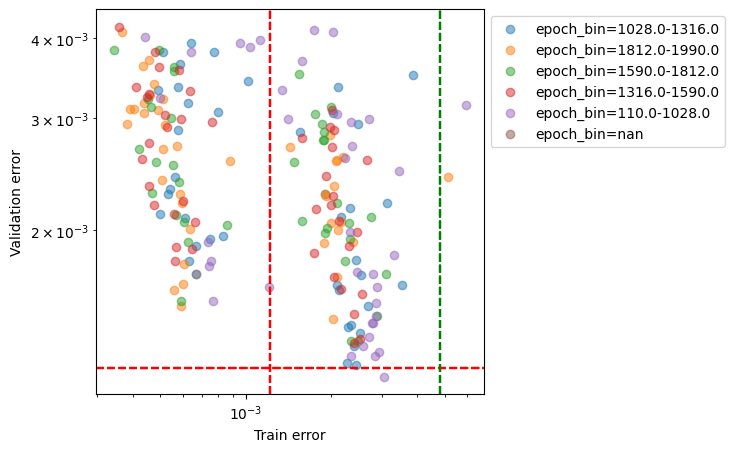

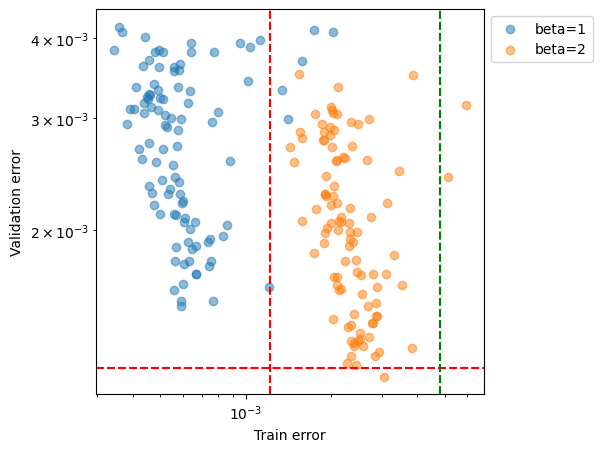

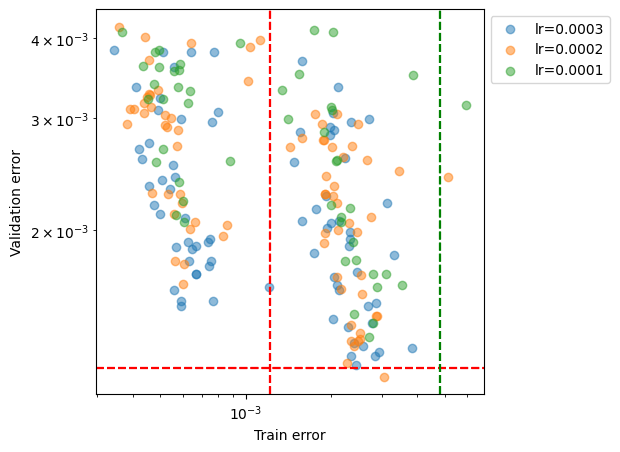

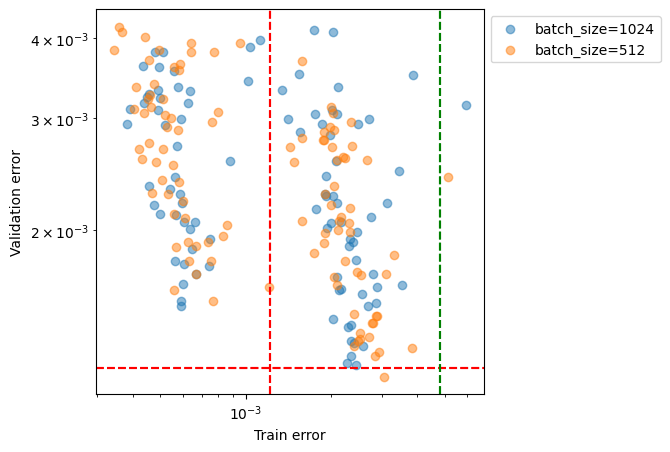

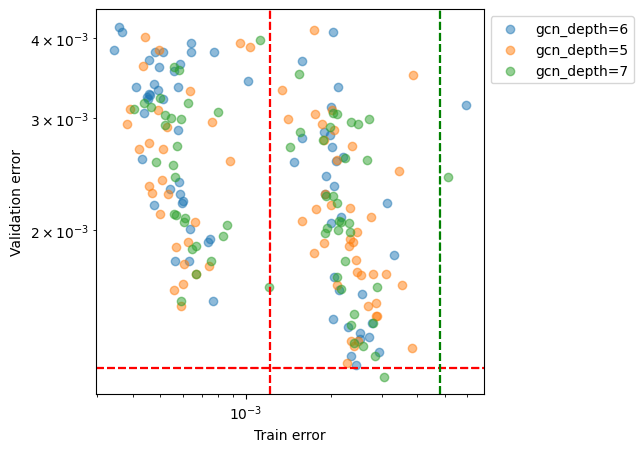

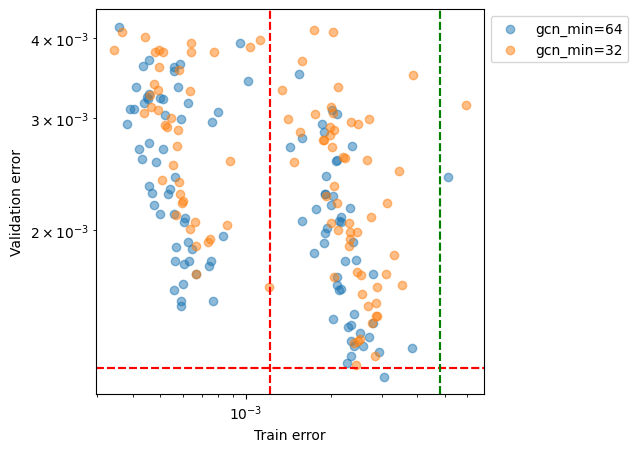

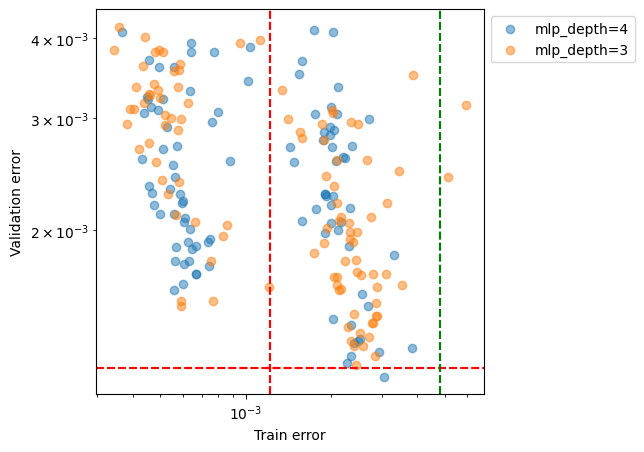

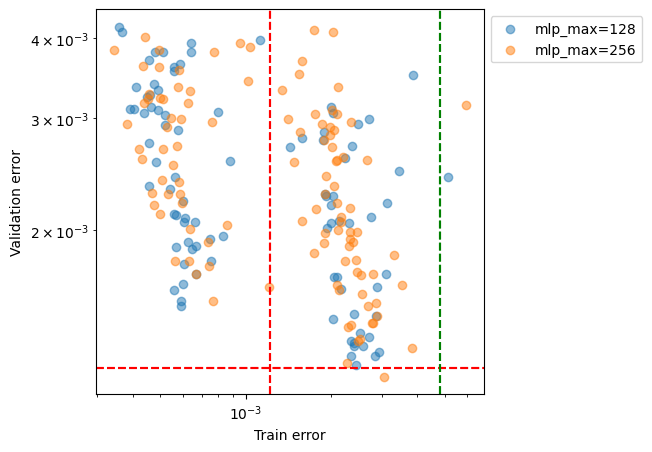

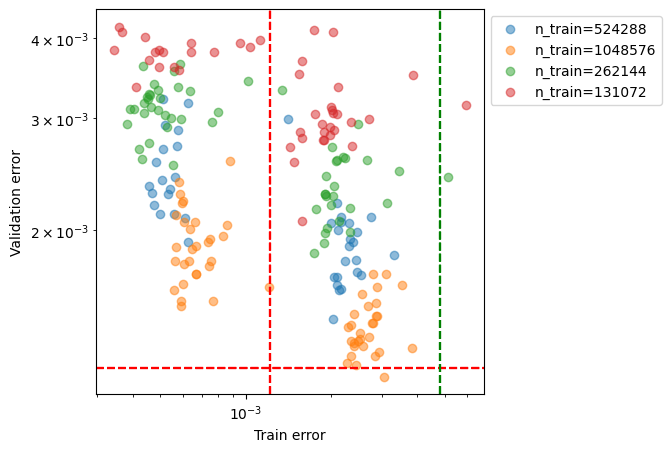

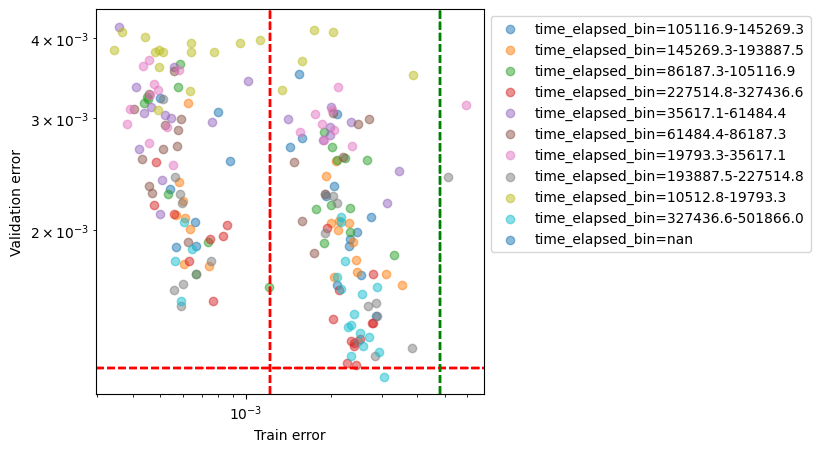

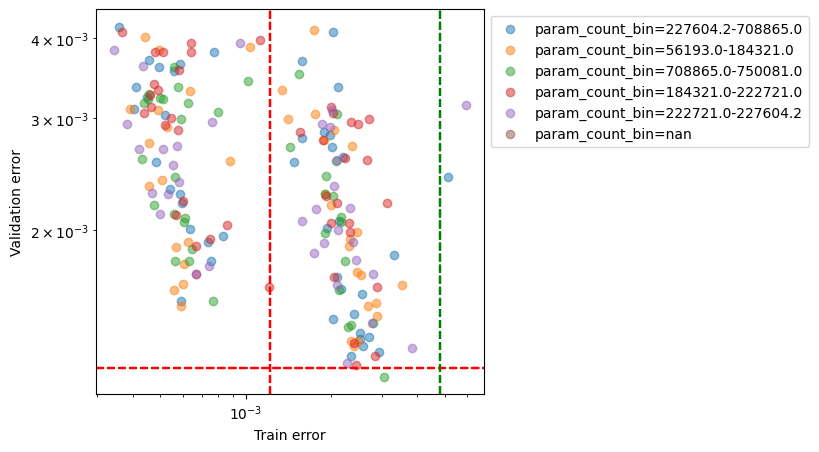

In [ ]:
plt.close('all')
for col in ["epoch_bin", "beta", "lr","batch_size"	,"gcn_depth",	
            "gcn_min",	"mlp_depth",	"mlp_max",	
            "n_train", "time_elapsed_bin", "param_count_bin", ]:
    plot_by_variables(df_v02, col)

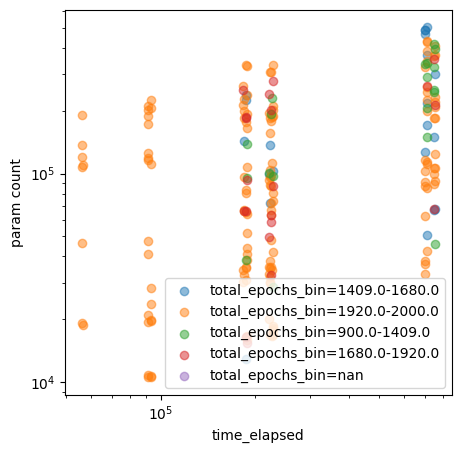

In [25]:
# Here we will plot the timing and parameter count for each run versus the choice of hyperparameters
def plot_by_variables_timing(df, col_name):
    """Plot the validation error vs train error in different colors for each unique value of col_name."""
    colors = plt.cm.rainbow(np.linspace(0, 1, len(df[col_name].unique())))
    fig, ax = plt.subplots(figsize=(5, 5))
    for col_val, color in zip(df[col_name].unique(), colors):
        half = df[df[col_name] == col_val]
        x = half["param_count"]
        y = half["time_elapsed"]
        ax.scatter(x, y, alpha=0.5, label=f"{col_name}={col_val}")
        ax.set_xlabel("time_elapsed")
        ax.set_ylabel("param count")
        ax.loglog()
        ax.legend()

for col in ["total_epochs_bin"]:
# for col in ["beta", "lr","batch_size"	,"gcn_depth",	
#             "gcn_min",	"mlp_depth",	"mlp_max",	
#             "n_train", "time_elapsed_bin", "param_count_bin", ]:
    plot_by_variables_timing(df_v02, col)

array([[<Axes: title={'center': 'epoch'}>]], dtype=object)

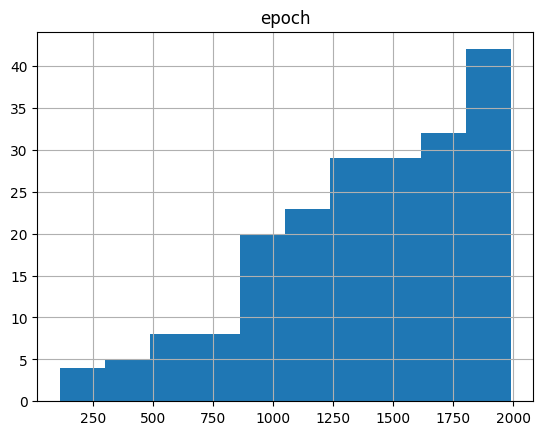

In [31]:
# df_v02.hist("total_epochs")
# unfortunately we didn't have enough epochs for a lot of these runs...
df_v02.hist("epoch")

### What do we see?
 - depth 6 and 7 models are really slow
 - there are a bunch of param counts > 700,000 and these consume a shitload of time.
 - beta=2 is doing visibly better in validation.
 - parameter count has a lot more effect than training data ccount! This is promising, I can do the training sweep. The problem is that my minimum runtime was 27 hours, typical was 2*10^5 i.e. 50 hours....
 - gcn_min 32 seems not appreciably worse than 64, so we could potentially cut out that. I think this is justified since I'm studying relative performance anyways. 
 - batch size doesn't really influence much, lets go with 1024
 - we ran out of epochs for a good chunk of runs :(

Decisions:
 - remove mlp_max=256
 - remove depth=7, add depth=4
 - add 2 million, 4 million training data
 - remove 512 batch size
 - remove lr=0.0001, add lr=0.0004
 - keep gcn_min 32 and 64; i would like to argue that "bigger beta is worth more than hyperparameter tuning"
 - add beta=3, and another 100 experiments


array([[<Axes: title={'center': 'vs_minweight'}>]], dtype=object)

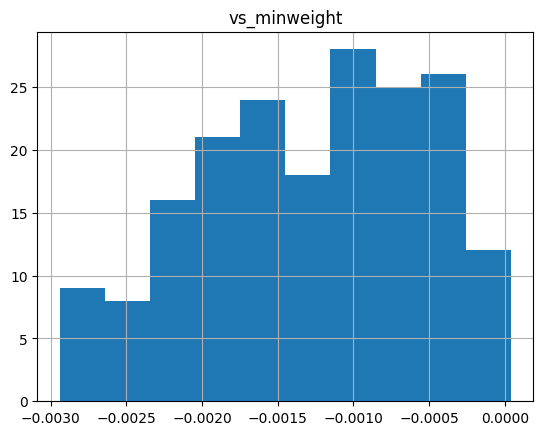

In [16]:
df.hist("vs_minweight")

#### Recovery script